<a href="https://colab.research.google.com/github/nauraalwa/AI-styled-Tic-Tac-Toe/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

import kagglehub

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 1.26.4
Pandas version 2.2.2


100%|██████████| 385M/385M [00:02<00:00, 160MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [ ]:
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

dataset = PlayingCardDataset(
    data_dir='/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
)

len(dataset)





7624

41


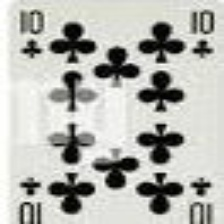

In [ ]:
image, label = dataset[6000]
print(label)
image

In [ ]:
#create a dictionary to match the label with the image
#class_to_idx dictionary maps class names to their numerical index (we call this as label)
#k represents each class name, v represents each numerical index
#v:k creates a reversed dictionary

data_dir='/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [ ]:
#Resize all of the images so that they are in the same size
#Then, transform all of the images into tensor

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir='/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
dataset = PlayingCardDataset(data_dir, transform)

In [ ]:
image, label = dataset[100]
image.shape

#shows the image tensor in index 100
#3 is the Red, Green, Blue channels (specifically for image tensors), 128 is the size

torch.Size([3, 128, 128])

In [ ]:
#iterate over the dataset
for image, label in dataset:
  break

In [ ]:
#Batching the dataset
#Train the model faster in batches rather than one at a time

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
  break

In [ ]:
images.shape, labels.shape

#shows the size of the 32 tensors, and it shows the 32 labels

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [ ]:
labels #labels are random cuz shuffle is true

tensor([52, 12, 10, 42, 32, 25, 10, 29, 32, 42, 31, 34, 51, 34, 31, 43, 14,  9,
        47, 44, 39, 11, 44, 27,  8, 29, 22, 38, 13, 33, 44, 14])

In [ ]:
class SimpleCardClassifier(nn.Module):
  def __init__(self, num_classes=53):
    super(SimpleCardClassifier, self).__init__()
    #we choose our neural network model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    # self.base_model.children() returns an iterable of layers (e.g., from a pre-trained model).
    # list(self.base_model.children()) converts that iterable into a list.
    # [:-1] removes the last element from the list (negative indexing in Python).
    # nn.Sequential(*...) reconstructs the model without the last layer.

    # In fine-tuning, the last layer is usually removed to replace it with a new output layer suited for a different number of classes.

    enet_out_size = 1280

    #Make the classifier layers
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(enet_out_size, num_classes)
    )

    #define the forward function to move our data forward through the next layers
  def forward(self, x):
    #connect the layers, self is our input and x is our output
    x = self.features(x)
    output = self.classifier(x)
    return output


In [ ]:
#print out model

model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

# Convert model to a string using str(model).
# Take only the first 500 characters of that string.
# [:500] is Python slicing, where:
# 0 (default) is the starting index.
# 500 is the stopping index (not included).
# It extracts a substring from index 0 to 499.

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [ ]:
example_out = model(images)
example_out.shape #[batch_size, num_classes] num_classes is the number of output, in this case there are 53 card types

torch.Size([32, 53])

In [ ]:
#loss function
criterion = nn.CrossEntropyLoss()

# measures how well a model’s predictions match the actual target values. The goal of training is to minimize this loss.
# nn.CrossEntropyLoss() used when the output is categorical (e.g., classifying images, text, or objects).

#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#lr is learning rate, the smaller it is, the slower the model is learning

In [ ]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


In [ ]:
#now we setup the datasets to train the model

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'
val_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid'
test_folder = '/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(val_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
num_epochs = 7 #how many times the data will go through the layers / be trained
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device) #insert model to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, label in tqdm(train_loader, desc='Training loop'):
      images, labels = images.to(device), label.to(device) #insert data to device
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
      for images, labels in tqdm(val_loader, desc='Validation loop'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/7 - Train loss: 1.6202643703813944, Validation loss: 0.37408871898111307


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/7 - Train loss: 0.5759418693381867, Validation loss: 0.2788548363829559


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/7 - Train loss: 0.3533326089773073, Validation loss: 0.19426173920708023


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/7 - Train loss: 0.22303482451928625, Validation loss: 0.19312606670384136


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/7 - Train loss: 0.19134067684013284, Validation loss: 0.19973375898487164


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/7 - Train loss: 0.18303572528400427, Validation loss: 0.13634147835227678


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/7 - Train loss: 0.1510775070227018, Validation loss: 0.16080205446847204


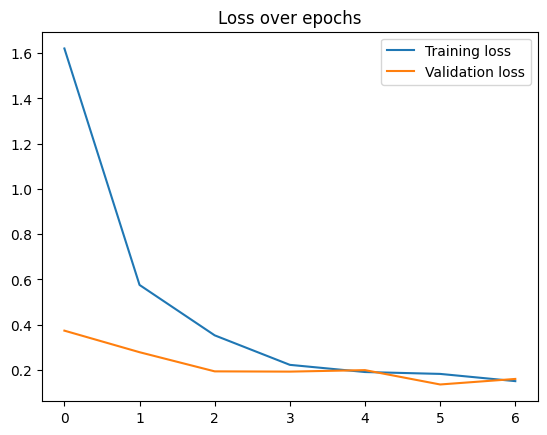

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

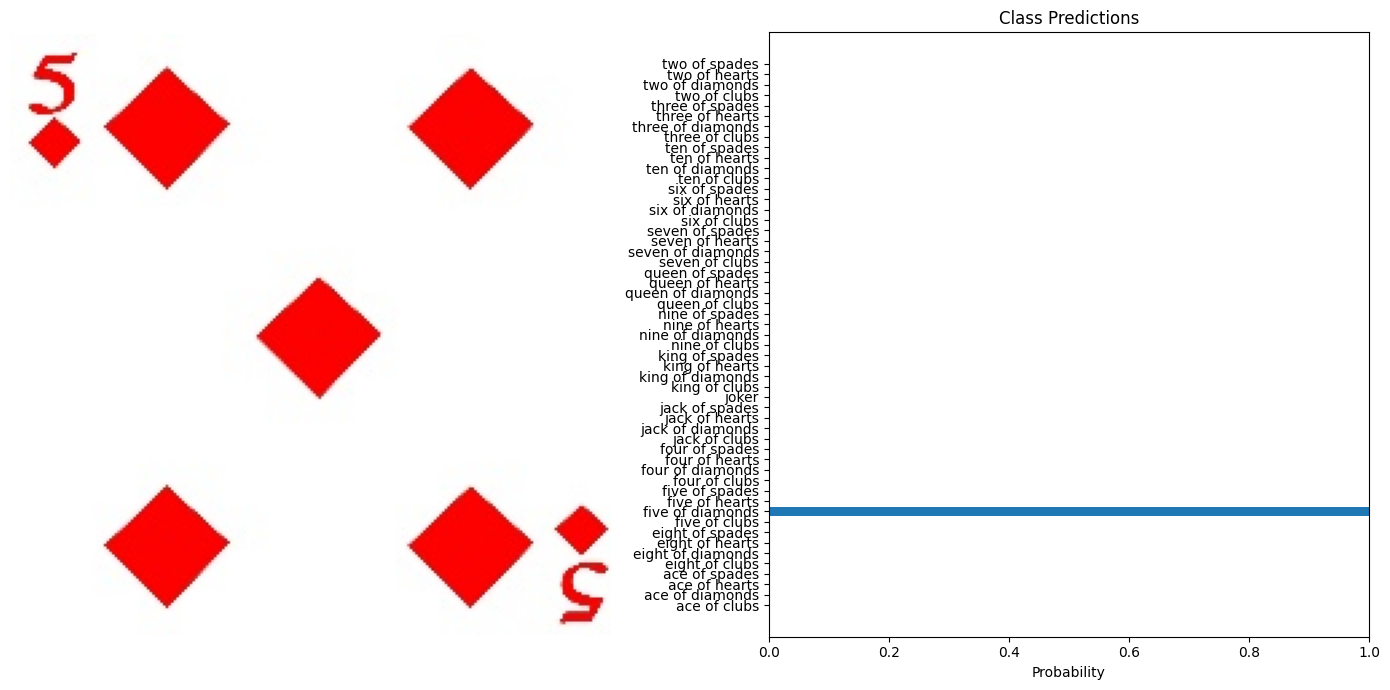

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

# New section